In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.compose import ColumnTransformer
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sales_forecasting.utils import timeseries_split
from sales_forecasting.plot import plot_timeseries, plot_feature_importance
from sales_forecasting.features import col_name

In [4]:
df = pd.read_parquet(".data/df_agg_monthly_oversampled.parquet")

In [5]:
train_split, valid_split = timeseries_split(df, max_month=33, col='date_block_num', continuous=False)
train_test_split, test_split = timeseries_split(df, max_month=34, col='date_block_num', continuous=False)

In [6]:
target_col = 'item_cnt_month'
train_target, valid_target = train_split[target_col].clip(0, 20), valid_split[target_col].clip(0, 20)

In [7]:
cols_to_drop = [target_col, 'date_block_num']
X_train, X_valid = train_split.drop(columns=cols_to_drop), valid_split.drop(columns=cols_to_drop)

# MLP

In [ ]:
X_train, X_valid = train_split.drop(columns=['shop_id', 'item_id']), valid_split.drop(columns=['shop_id', 'item_id'])

In [ ]:
ohe_cols = ['city_id', 'item_category_id', 'general_item_category_id', 'date_month']
num_cols = list(np.setdiff1d(X_train.columns, ohe_cols))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing.StandardScaler(), num_cols),
        ('cat', preprocessing.OneHotEncoder(handle_unknown='ignore'), ohe_cols)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

In [ ]:
class SalesPredictionMLPModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: list[int], dropout_rate: float, batch_norm: bool = True):
        super(SalesPredictionMLPModel, self).__init__()
        
        layers = []
        dims = [input_dim] + hidden_dim
        for in_dim, out_dim in zip(dims, dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if batch_norm:
                layers.append(nn.BatchNorm1d(out_dim))
            layers.extend([nn.Dropout(p=dropout_rate), nn.ReLU()])
        layers.append(nn.Linear(dims[-1], 1))

        self.ff = nn.Sequential(*layers)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.ff(X)

In [ ]:
class SalesMLPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 1024

train_dataset = SalesMLPDataset(X_train_preprocessed, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = SalesMLPDataset(X_valid_preprocessed, valid_target)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

dropout_rate = 0.2
input_dim = X_train_preprocessed.shape[1]
hidden_dim = [64, 32]
lr = 1e-5
device = torch.device("cpu")

model = SalesPredictionMLPModel(input_dim, hidden_dim, dropout_rate=dropout_rate).to(device)
criterion = F.mse_loss
optimizer = optim.Adam(model.parameters(), lr=lr)


In [208]:
from typing import Callable

def train(
    model: nn.Module, 
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    device: torch.device, 
    epoch: int, 
    print_every: None | int = None
) -> float:
    model.train()
    train_loss = 0.

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        loss_item = loss.detach().cpu().item()

        if print_every is not None and batch_idx % print_every == 0:
            print(
                "Train (Batch): [{}/{} ({:.0f}%)]\tTrain Loss: {:.4f} \tTrain RMSE: {:.4f}".format(
                    batch_idx * len(data), len(train_loader.dataset), 100.0 * batch_idx / len(train_loader), loss_item, loss_item ** 0.5
                ) # type: ignore
            )
        train_loss += loss_item

    return train_loss


def test(
    model: nn.Module, 
    loss_fn: Callable,
    device: torch.device,
    test_loader: DataLoader, 
    print_every: None | int = None
) -> float:
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss =  loss_fn(output, target, reduction="sum")

            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)

    if print_every is not None:
        print(
            "\nTest: Test loss: {:.4f} \t Test RMSE: {:.4f}\n".format(test_loss, test_loss ** 2) # type: ignore
        )
    
    return test_loss

In [ ]:
history = {
    'train_loss': [],
    'val_loss': []
}
for epoch in tqdm(range(1, 6)):
    history['train_loss'].append(train(model, criterion, optimizer, train_loader, device, epoch, print_every=1000))
    history['val_loss'].append(test(model, criterion, device, valid_loader))

history['train_loss'] = np.array(history['train_loss'])
history['val_loss'] = np.array(history['val_loss'])

In [ ]:
train_loss

In [ ]:
history['train_loss'] = np.array(history['train_loss'])
history['val_loss'] = np.array(history['val_loss'])

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label="Training Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'] ** 0.5, label="Training RMSE")
    plt.plot(history['val_loss'] ** 0.5, label="Validation RMSE")
    plt.title("RMSE Curve")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()

    plt.show()

plot_history(history)

# RNN

In [8]:
X_train = X_train.assign(item_cnt_month=train_target)

In [15]:
X_train

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,shop_id,item_id,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,lagged_1,lagged_2,...,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy,item_cnt_month
0,0,0,0,40,11,8,0.866211,-0.500000,0,0,...,169.0,1.0,4488.0,1.000000,270.50,1.163086,264.00,1.080078,0,0
1,0,0,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,4488.0,1.000000,263.50,1.150391,265.50,1.080078,1,0
2,0,0,0,40,11,10,0.500000,-0.866211,0,0,...,169.0,1.0,4488.0,1.000000,263.75,1.170898,263.75,1.087891,2,0
3,0,0,0,40,11,11,0.258789,-0.965820,0,0,...,169.0,1.0,4488.0,1.000000,262.25,1.138672,264.00,1.089844,3,0
4,0,0,0,40,11,0,0.000000,1.000000,0,0,...,169.0,1.0,4488.0,1.000000,262.50,1.228516,262.00,1.131836,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460948,59,22169,30,69,14,4,0.866211,0.500000,0,0,...,299.0,1.0,169.0,1.069336,1042.00,1.000000,1093.00,1.047852,14,0
29460949,59,22169,30,69,14,5,0.965820,0.258789,0,0,...,299.0,1.0,169.0,1.069336,489.00,1.000000,1130.00,1.031250,15,0
29460950,59,22169,30,69,14,6,1.000000,0.000000,0,0,...,299.0,1.0,169.0,1.069336,1080.00,1.125000,938.50,1.047852,16,0
29460951,59,22169,30,69,14,7,0.965820,-0.258789,0,0,...,299.0,1.0,169.0,1.069336,553.00,1.151367,738.50,1.071289,17,0


In [ ]:
embed_cols = ['shop_id', 'item_id', 'city_id', 'item_category_id', 'general_item_category_id']
X_train[embed_cols].drop_duplicates().reset_index(drop=True)

,shop_id,item_id,city_id,item_category_id,general_item_category_id
0,0,0,0,40,11
1,0,1,0,76,15
2,0,2,0,40,11
3,0,3,0,40,11
4,0,4,0,40,11
...,...,...,...,...,...
1194531,59,22165,30,31,8
1194532,59,22166,30,54,12
1194533,59,22167,30,49,12
1194534,59,22168,30,62,14


In [47]:
seq_cols = np.setdiff1d(X_train.columns, embed_cols + ["item_cnt_month"])
embed_cols = ['shop_id', 'item_id', 'city_id', 'item_category_id', 'general_item_category_id']
embed_entity_index = X_train[embed_cols].drop_duplicates().reset_index(drop=True)


vector_tuples = []
for (shop_id, item_id), group in X_train.groupby(['shop_id', 'item_id']):
    embed_entities = embed_entity_index[(embed_entity_index.shop_id == shop_id) & (embed_entity_index.item_id == item_id)].values
    seq_matrix = group[seq_cols].values
    target_array = group['item_cnt_month'].values
    vector_tuples.append((embed_entities, seq_matrix, target_array))

In [51]:
import pickle

with open('.data/vector_tuples.pkl', 'wb') as f:
    pickle.dump(vector_tuples, f)

In [150]:
def pad_sequences(matrices):
    L = len(matrices)
    D = matrices[0].shape[1]
    K = max(matrix.shape[0] for matrix in matrices)

    padded_tensor = torch.zeros((L, K, D), dtype=torch.float32)

    for i, matrix in enumerate(matrices):
        n = matrix.shape[0]
        padded_tensor[i, :n, :] = torch.tensor(matrix, dtype=torch.float32)
    return padded_tensor

def pad_sequences1d(sequences):
    L = len(sequences)
    K = max(len(seq) for seq in sequences)

    padded_tensor = torch.zeros((L, K), dtype=torch.float32)

    for i, seq in enumerate(sequences):
        n = len(seq)
        padded_tensor[i, :n] = torch.tensor(seq, dtype=torch.float32)
    return padded_tensor

In [173]:
class SalesDataset(Dataset):
    def __init__(self, df_tuples_array: list[tuple[np.ndarray, np.ndarray, np.ndarray]]):
        self.df = df_tuples_array
        self.embed_entities = torch.tensor([x[0] for x in self.df], dtype=torch.long).squeeze(1)
        self.seq_matr = pad_sequences([torch.tensor(x[1], dtype=torch.float32) for x in self.df])
        
        self.target_lengths = torch.tensor([len(x[2]) for x in self.df], dtype=torch.long)
        self.target_last_values = torch.tensor([x[2][-1] for x in self.df], dtype=torch.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.embed_entities[idx], 
                self.seq_matr[idx],
                self.target_lengths[idx], 
                self.target_last_values[idx])


In [200]:
class SalesPredictionModel(nn.Module):
    def __init__(self, emb_cardinality, embedding_size, dropout_rate, seq_input_size):
        super(SalesPredictionModel, self).__init__()
        
        # Embedding layers for categorical variables
        self._embedding_size = embedding_size
        self._emb_cardinality = emb_cardinality
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings, self._embedding_size) 
            for num_embeddings in self._emb_cardinality
        ])
        self._emb_dim_sum = len(self._emb_cardinality) * self._embedding_size

        # LSTM layer
        self._lstm_input_size = seq_input_size
        self._lstm_hidden_size = 2 * embedding_size
        self.lstm = nn.LSTM(
            input_size=self._lstm_input_size,
            hidden_size=self._lstm_hidden_size,
            batch_first=True
        )
        
        # Fully connected layer
        self._fc_input_size = self._lstm_hidden_size + self._emb_dim_sum
        self.fc = nn.Linear(self._fc_input_size, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.1)

    def forward(self, embed, seq, tgt_ix):
        # Embedding layers
        embedded_features = [embedding(embed[:, i]) for i, embedding in enumerate(self.embeddings)]
        emb_tensors = torch.cat(embedded_features, dim=1)
        #emb_tensors = self.dropout(emb_tensors) 

        # LSTM
        _, (lstm_hidden_state, _) = self.lstm(seq)
        lstm_hidden_state = lstm_hidden_state[-1]

        # Concatenate embeddings and LSTM output
        concatenated = torch.cat([emb_tensors, lstm_hidden_state], dim=1)

        output = self.fc(concatenated)

        return output

In [214]:
batch_size = 1024

train_dataset = SalesDataset(vector_tuples)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# val_dataset = SalesDataset(df_val)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Parameters
emb_cardinality = X_train.shop_id.max()+1, X_train.item_id.max()+1, X_train.city_id.max()+1, X_train.item_category_id.max()+1, X_train.general_item_category_id.max()+1
embedding_size = 8
dropout_rate = 0.1
seq_input_size = 26
lr = 1e-3
device = torch.device("cpu")

model = SalesPredictionModel(emb_cardinality, embedding_size, dropout_rate, seq_input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_67271/1370659372.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor[i, :n, :] = torch.tensor(matrix, dtype=torch.float32)


In [215]:
model

SalesPredictionModel(
  (embeddings): ModuleList(
    (0): Embedding(60, 8)
    (1): Embedding(22170, 8)
    (2): Embedding(31, 8)
    (3): Embedding(84, 8)
    (4): Embedding(20, 8)
  )
  (lstm): LSTM(26, 16, batch_first=True)
  (fc): Linear(in_features=56, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [216]:
def train(
    model: nn.Module, 
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    device: torch.device, 
    epoch: int, 
    print_every: None | int = None
) -> float:
    model.train()
    train_loss = 0.

    for batch_idx, batch in enumerate(train_loader):
        embed, seq, tgt_ix, target = batch
        optimizer.zero_grad()
        output = model(embed, seq, tgt_ix)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        loss_item = loss.detach().cpu().item()

        if print_every is not None and batch_idx % print_every == 0:
            print(
                "Train (Batch): [{}/{} ({:.0f}%)]\tTrain Loss: {:.4f} \tTrain RMSE: {:.4f}".format(
                    batch_idx * len([batch[0]]), len(train_loader.dataset), 100.0 * batch_idx / len(train_loader), loss_item, loss_item ** 0.5
                ) # type: ignore
            )
        train_loss += loss_item

    return train_loss


def test(
    model: nn.Module, 
    loss_fn: Callable,
    device: torch.device,
    test_loader: DataLoader, 
    print_every: None | int = None
) -> float:
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss =  loss_fn(output, target, reduction="sum")

            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)

    if print_every is not None:
        print(
            "\nTest: Test loss: {:.4f} \t Test RMSE: {:.4f}\n".format(test_loss, test_loss ** 2) # type: ignore
        )
    
    return test_loss

In [217]:
history = {
    'train_loss': [],
    'val_loss': []
}
for epoch in tqdm(range(1, 6)):
    history['train_loss'].append(train(model, criterion, optimizer, train_loader, device, epoch, print_every=1000))
    #history['val_loss'].append(test(model, criterion, device, valid_loader))

history['train_loss'] = np.array(history['train_loss'])
#history['val_loss'] = np.array(history['val_loss'])

  0%|          | 0/5 [00:00<?, ?it/s]/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train (Batch): [0/1194536 (0%)]	Train Loss: 0.8511 	Train RMSE: 0.9226
Train (Batch): [1000/1194536 (86%)]	Train Loss: 0.2297 	Train RMSE: 0.4793


/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([552])) that is different to the input size (torch.Size([552, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 20%|██        | 1/5 [00:16<01:07, 16.78s/it]

Train (Batch): [0/1194536 (0%)]	Train Loss: 0.0437 	Train RMSE: 0.2090
Train (Batch): [1000/1194536 (86%)]	Train Loss: 0.0692 	Train RMSE: 0.2631


 40%|████      | 2/5 [00:33<00:49, 16.57s/it]

Train (Batch): [0/1194536 (0%)]	Train Loss: 0.5377 	Train RMSE: 0.7333
Train (Batch): [1000/1194536 (86%)]	Train Loss: 0.0770 	Train RMSE: 0.2775


 60%|██████    | 3/5 [00:49<00:32, 16.40s/it]

Train (Batch): [0/1194536 (0%)]	Train Loss: 0.1807 	Train RMSE: 0.4251
Train (Batch): [1000/1194536 (86%)]	Train Loss: 0.0389 	Train RMSE: 0.1973


 80%|████████  | 4/5 [01:05<00:16, 16.39s/it]

Train (Batch): [0/1194536 (0%)]	Train Loss: 0.8768 	Train RMSE: 0.9364
Train (Batch): [1000/1194536 (86%)]	Train Loss: 0.0635 	Train RMSE: 0.2519


100%|██████████| 5/5 [01:22<00:00, 16.41s/it]


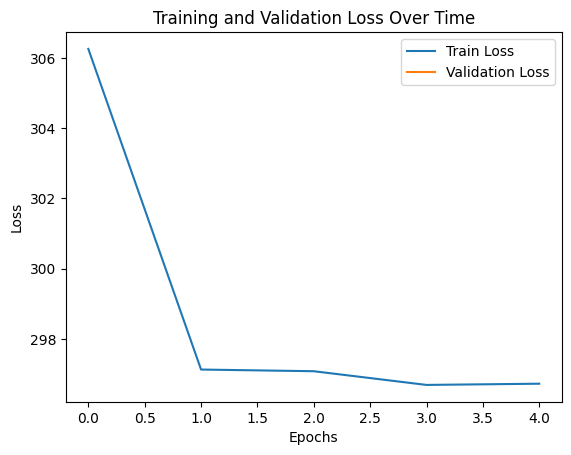

In [218]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [ ]:
# Instantiate the dataset
train_dataset = SalesDataset(df_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Parameters
num_shops = df_val['shop_id'].max() + 1        # Example: total unique shops
num_items = df_val['item_id'].max() + 1       # Example: total unique items
num_categories = df_val['item_category_id'].max() + 1    # Example: total unique categories

# Instantiate the model
model = SalesPredictionModel(num_shops, num_items, num_categories, embedding_size, dropout_rate=dropout_rate)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [ ]:
num_epochs = 33

history = {
    'train_loss': []
}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        shop_ids, item_ids, category_ids, sales_arrays, targets = batch

        optimizer.zero_grad()
        predictions = model(shop_ids, item_ids, category_ids, sales_arrays)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    history['train_loss'].append(running_loss / len(train_loader))    
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.2f} \
[rmse: {np.sqrt(running_loss/len(train_loader)):.2f}]')

In [ ]:
df_test_raw = pd.read_csv(".data/test.csv", index_col=[0]).assign(date_block_num=34, item_cnt_month=np.nan)
df_test_vectors = transform_data_to_features(pd.concat([test_split_featurized, df_test_raw]), 35)
df_test = df_test_vectors.merge(pd.read_csv(".data/items.csv")[['item_id', 'item_category_id']], on='item_id', how='left')

In [ ]:
test_dataset = SalesDataset(df_test)

In [ ]:
preds = []

model.eval()
with torch.no_grad():
    for i in range(len(test_dataset)):
        elem = (_.unsqueeze(0) for _ in test_dataset[i])
        shop_ids, item_ids, category_ids, sales_arrays, _ = elem

        predictions = model(shop_ids, item_ids, category_ids, sales_arrays)
        preds.append(predictions.item())

In [ ]:
df_submission = df_test_raw \
    .reset_index()[['ID', 'shop_id', 'item_id']] \
    .merge(
        df_test.assign(predictions=preds)[['shop_id', 'item_id', 'predictions']], 
        on=['shop_id', 'item_id'], 
        how='left'
    )[['ID', 'predictions']] \
    .rename(columns={'predictions': 'item_cnt_month'})

In [ ]:
df_submission['item_cnt_month'] = df_submission['item_cnt_month'].clip(0, 20)

In [ ]:
df_submission.to_csv(".data/submission_lstm2.csv", index=False)